In [1]:
%matplotlib inline


# Model-based and sequential feature selection

This example illustrates and compares two approaches for feature selection:
:class:`~sklearn.feature_selection.SelectFromModel` which is based on feature
importance, and
:class:`~sklearn.feature_selection.SequentialFeatureSelection` which relies
on a greedy approach.

We use the Diabetes dataset, which consists of 10 features collected from 442
diabetes patients.

Authors: `Manoj Kumar <mks542@nyu.edu>`_,
`Maria Telenczuk <https://github.com/maikia>`_, Nicolas Hug.

License: BSD 3 clause


## Loading the data

We first load the diabetes dataset which is available from within
scikit-learn, and print its description:



In [2]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

## Feature importance from coefficients

To get an idea of the importance of the features, we are going to use the
:class:`~sklearn.linear_model.RidgeCV` estimator. The features with the
highest absolute `coef_` value are considered the most important.
We can observe the coefficients directly without needing to scale them (or
scale the data) because from the description above, we know that the features
were already standardized.
For a more complete example on the interpretations of the coefficients of
linear models, you may refer to
`sphx_glr_auto_examples_inspection_plot_linear_model_coefficient_interpretation.py`.



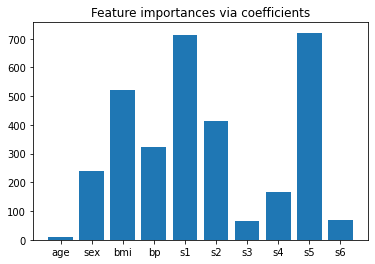

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X, y)
importance = np.abs(ridge.coef_)
feature_names = np.array(diabetes.feature_names)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

## Selecting features based on importance

Now we want to select the two features which are the most important according
to the coefficients. The :class:`~sklearn.feature_selection.SelectFromModel`
is meant just for that. :class:`~sklearn.feature_selection.SelectFromModel`
accepts a `threshold` parameter and will select the features whose importance
(defined by the coefficients) are above this threshold.

Since we want to select only 2 features, we will set this threshold slightly
above the coefficient of third most important feature.



In [4]:
from sklearn.feature_selection import SelectFromModel
from time import time

threshold = np.sort(importance)[-3] + 0.01

tic = time()
sfm = SelectFromModel(ridge, threshold=threshold).fit(X, y)
toc = time()
print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

Features selected by SelectFromModel: ['s1' 's5']
Done in 0.001s


## Selecting features with Sequential Feature Selection

Another way of selecting features is to use
:class:`~sklearn.feature_selection.SequentialFeatureSelector`
(SFS). SFS is a greedy procedure where, at each iteration, we choose the best
new feature to add to our selected features based a cross-validation score.
That is, we start with 0 features and choose the best single feature with the
highest score. The procedure is repeated until we reach the desired number of
selected features.

We can also go in the reverse direction (backward SFS), *i.e.* start with all
the features and greedily choose features to remove one by one. We illustrate
both approaches here.



In [5]:
from sklearn.feature_selection import SequentialFeatureSelector

tic_fwd = time()
sfs_forward = SequentialFeatureSelector(
    ridge, n_features_to_select=2, direction="forward"
).fit(X, y)
toc_fwd = time()

tic_bwd = time()
sfs_backward = SequentialFeatureSelector(
    ridge, n_features_to_select=2, direction="backward"
).fit(X, y)
toc_bwd = time()

print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
)
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

Features selected by forward sequential selection: ['bmi' 's5']
Done in 0.096s
Features selected by backward sequential selection: ['bmi' 's5']
Done in 0.250s


## Discussion

Interestingly, forward and backward selection have selected the same set of
features. In general, this isn't the case and the two methods would lead to
different results.

We also note that the features selected by SFS differ from those selected by
feature importance: SFS selects `bmi` instead of `s1`. This does sound
reasonable though, since `bmi` corresponds to the third most important
feature according to the coefficients. It is quite remarkable considering
that SFS makes no use of the coefficients at all.

To finish with, we should note that
:class:`~sklearn.feature_selection.SelectFromModel` is significantly faster
than SFS. Indeed, :class:`~sklearn.feature_selection.SelectFromModel` only
needs to fit a model once, while SFS needs to cross-validate many different
models for each of the iterations. SFS however works with any model, while
:class:`~sklearn.feature_selection.SelectFromModel` requires the underlying
estimator to expose a `coef_` attribute or a `feature_importances_`
attribute. The forward SFS is faster than the backward SFS because it only
needs to perform `n_features_to_select = 2` iterations, while the backward
SFS needs to perform `n_features - n_features_to_select = 8` iterations.

